In [1]:
import matplotlib.pyplot as mp
import matplotlib

import pandas
import geopandas
import cartopy
import pygsheets
import numpy
import leafmap
import shapely
import pathlib
import textwrap

import gemplot

In [2]:
import importlib
import gemplot
importlib.reload(gemplot)
from gemplot import *

# import terminals and pipelines

In [10]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')

# terminals
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A3')

# remove oil export terminals
terms_df_orig = terms_df_orig[terms_df_orig.Fuel.isin(['Oil','LNG'])]
# remove anything without a wiki page
terms_df_orig = terms_df_orig[terms_df_orig['Wiki']!='']

In [12]:
no_lonlat_options = [
    'Unknown',
    'TBD',
    ''
]

# (1) copy, clean up
to_convert_df = terms_df_orig.copy()
to_convert_df = to_convert_df[~(to_convert_df['Latitude'].isin(no_lonlat_options)) |
                             ~(to_convert_df['Longitude'].isin(no_lonlat_options))]

# also keep the non-converted ones separate
not_converted_df = terms_df_orig.copy()
not_converted_df = not_converted_df[(not_converted_df['Longitude'].isin(no_lonlat_options)) | 
                                    (not_converted_df['Latitude'].isin(no_lonlat_options))]
# add a dummy column so that the dimensions match with converted wkt pipelines
not_converted_df.assign(ColName='geometry')
not_converted_df['geometry'] = [shapely.geometry.Point()]*not_converted_df.shape[0]
not_converted_df.reset_index(drop=True)
not_converted_gdf = geopandas.GeoDataFrame(not_converted_df, geometry=not_converted_df['geometry'])

# (2) convert all terminals
terms_df_converted = to_convert_df.copy()
terms_df_converted.assign(ColName='geometry')
terms_df_converted['geometry'] = to_convert_df[['Longitude','Latitude']].apply(shapely.geometry.Point, axis=1)
terms_df_converted = terms_df_converted.reset_index(drop=True)

# # (3) store in a GeoDataFrame, attach a projection, transform to a different one
terms_df_gdf = geopandas.GeoDataFrame(terms_df_converted, geometry=terms_df_converted['geometry'])
# terms_df_gdf = terms_df_gdf.set_crs('epsg:4326')
# terms_df_gdf_4087 = terms_df_gdf.to_crs('epsg:4087')

<Axes: >

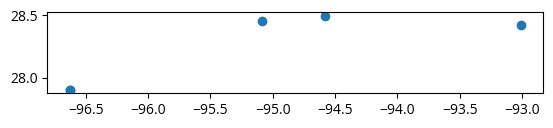

In [20]:
terms_id_list = ['T0734',
                 'T0739',
                 'T0993',
                 'T0994']

terms_df_gdf.loc[(terms_df_gdf.Fuel=='Oil')&
                (terms_df_gdf.Status=='Proposed')&
                (terms_df_gdf.TerminalID.isin(terms_id_list))].geometry.plot()

## pipelines

In [23]:
file_output = 'liquid'

#pipelines
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A3')
liquid_pipes = spreadsheet.worksheet('title','Oil/NGL pipelines').get_as_df(start='A3')

#pandas.concat([gas_pipes,liquid_pipes], ignore_index=True)
if file_output=="gas":
    all_pipes = gas_pipes.copy()
if file_output=="liquid":
    all_pipes = liquid_pipes.copy()

all_pipes = all_pipes.loc[all_pipes.RouteAccuracy!='']

In [24]:
geojson_path = '/Users/baird/Dropbox/_git_ALL/_github-repos-gem/'+\
'GOIT-GGIT-pipeline-routes/data/individual-routes/'+file_output+'-pipelines/'

geojson_route_files = list(
    pathlib.Path(
        geojson_path
    ).rglob('?????.geojson')
)

In [25]:
geojson_projectids = [str(i).split('/')[-1][:5] for i in geojson_route_files]

In [26]:
set(all_pipes.ProjectID.tolist())-set(geojson_projectids)

set()

In [27]:
set(geojson_projectids)-set(all_pipes.ProjectID.tolist())

set()

In [28]:
for idx,pid in enumerate(all_pipes.ProjectID.tolist()):
    try:
        file = geojson_path + pid + '.geojson'
        file_gdf = geopandas.read_file(file)
        file_geometry_dissolved = file_gdf.dissolve().geometry
        all_pipes.loc[all_pipes.ProjectID==pid,'geometry'] = file_geometry_dissolved[0]
    except:
        print(pid," geojson file either doesn't exist or has bad geometry")

In [29]:
all_pipes = all_pipes.loc[~all_pipes.geometry.isnull()]

In [47]:
all_pipes_gdf = geopandas.GeoDataFrame(all_pipes, geometry=all_pipes.geometry)
oil_pipes_gdf = all_pipes_gdf.loc[all_pipes_gdf.Fuel=='Oil']

# create maps

## gemplot colors

In [32]:
ff_palette = ["#580000", "#902C00", "#BF532C", "#F98C28", "#FFD370"]
purple_palette = ["#392E66", "#4F408C", "#7468A4", "#9A91BD", "#BFBAD5"]

gp_op = purple_palette[0]
gp_con = purple_palette[1]
gp_precon = purple_palette[2]
gp_ann = purple_palette[3]

lng_op = ff_palette[1]
lng_con = ff_palette[2]
lng_prop = ff_palette[3]

## map colors

In [33]:
#construction_color = matplotlib.colormaps['Reds'](0.75)

construction_color_terminals = ff_palette[0]
construction_color_gas_plants = ff_palette[1]
construction_color_pipelines = ff_palette[2]

proposed_color = matplotlib.colormaps['Oranges'](0.25)
#operating_color = '#c2c2c2'
other_land_color = '#ffffff'
other_land_alpha = 1
highlight_land_color = '#c2c2c2'
highlight_land_alpha = 0.4
water_color = '#a1bccc'
water_alpha = 0.3
operating_color = '0.25'
operating_terms_color = '0.666'
construction_lw = 2
construction_gas_lw = 1.5
ehb_alpha = 1.

## import gis data

In [63]:
ne_states_provinces_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
countries_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_50m_admin_0_countries_lakes/ne_50m_admin_0_countries_lakes.shp')
lakes_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_lakes/ne_10m_lakes.shp')
oceans_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_ocean/ne_10m_ocean.shp')

In [74]:
ne_states_provinces_gdf.adm0_a3#columns

0       ARG
1       URY
2       PAK
3       IND
4       IDN
       ... 
4589    MLT
4590    MLT
4591    MLT
4592    MLT
4593    MLT
Name: adm0_a3, Length: 4594, dtype: object

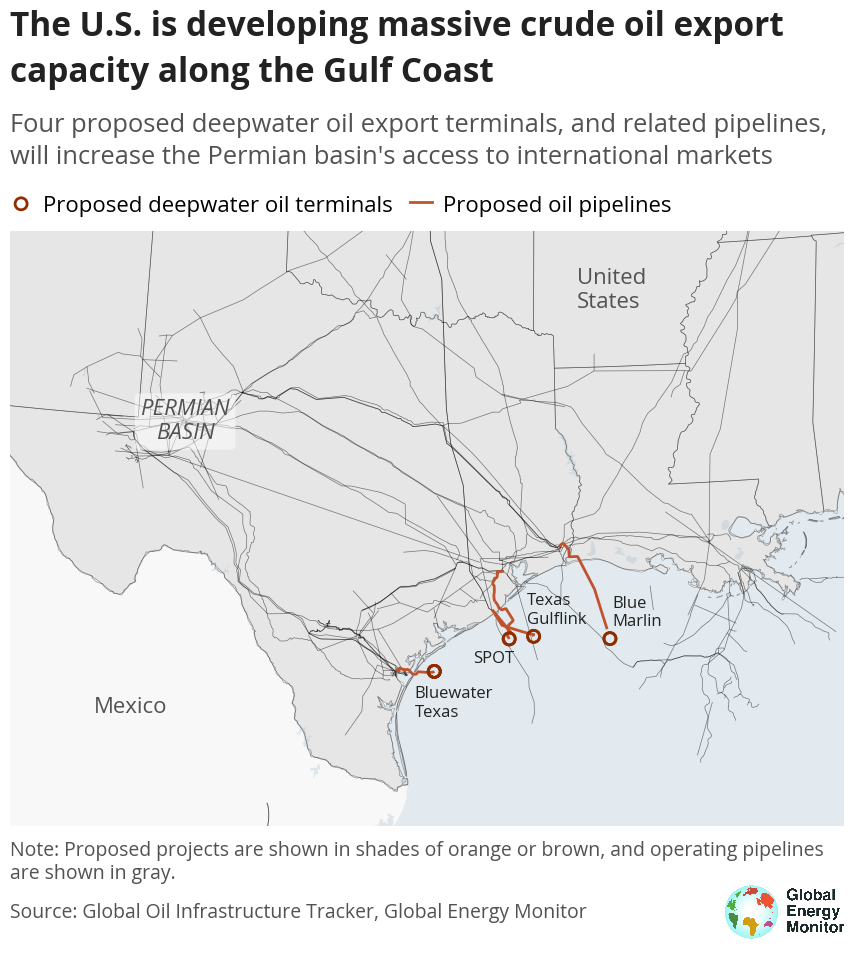

In [228]:
WHICH_COUNTRIES = ['United States of America']

term_size = 75

#map_proj = cartopy.crs.PlateCarree()
map_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96,
                                      central_latitude=40,
                                      false_easting=0,
                                      false_northing=0,
                                      standard_parallels=[20,60])
data_proj = cartopy.crs.PlateCarree()

width_pixels = 640 # 640 default
height_pixels = 450 # 450 default
fig = mp.figure(figsize=(width_pixels/72, height_pixels/72))
#fig.canvas.draw()

ax = fig.add_subplot(111, projection=map_proj)

other_land = ax.add_geometries(countries_gdf.loc[~countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                               facecolor=highlight_land_color, 
                               edgecolor='None', 
                               crs=data_proj, 
                               alpha=0.1)

highlight_land = ax.add_geometries(countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry'], 
                                   facecolor=highlight_land_color, 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

# highlight_land = ax.add_geometries(countries_gdf['geometry'], 
#                                    facecolor=highlight_land_color, 
#                                    edgecolor='0', 
#                                    linewidth=0.5,
#                                    crs=data_proj, 
#                                    alpha=highlight_land_alpha)

#highlight_geometry = countries_gdf.loc[countries_gdf.SOVEREIGNT.isin(WHICH_COUNTRIES)]['geometry']

states = ax.add_geometries(ne_states_provinces_gdf.loc[ne_states_provinces_gdf.adm0_a3=='USA']['geometry'], 
                                   facecolor='None', 
                                   edgecolor='0', 
                                   linewidth=0.5,
                                   crs=data_proj, 
                                   alpha=highlight_land_alpha)

lakes = ax.add_geometries(lakes_gdf['geometry'], 
                          facecolor=water_color, 
                          edgecolor='None', 
                          crs=data_proj, 
                          alpha=water_alpha)

oceans = ax.add_geometries(oceans_gdf['geometry'], 
                           facecolor=water_color, 
                           edgecolor='None', 
                           crs=data_proj, 
                           alpha=water_alpha)

# PIPELINES
ax.add_geometries(oil_pipes_gdf.loc[
                  (oil_pipes_gdf.Status.isin(['operating']))
                  ].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor='0', alpha=0.5,
                  linewidth=0.5, zorder=5)

# ax.add_geometries(oil_pipes_gdf.loc[
#                   (oil_pipes_gdf.Status.isin(['operating']))&
#                   (oil_pipes_gdf.Countries.str.contains('|'.join(['United States'])))].geometry, 
#                   crs=data_proj, 
#                   facecolor='None', 
#                   edgecolor=operating_color, 
#                   linewidth=0.5, zorder=5)

ax.add_geometries(oil_pipes_gdf.loc[
                  (oil_pipes_gdf.Status.isin(['proposed', 'construction']))&
                  (oil_pipes_gdf.Countries.str.contains('|'.join(['United States'])))].geometry, 
                  crs=data_proj, 
                  facecolor='None', 
                  edgecolor=ff_palette[2],
                  linewidth=2, zorder=6)

points_list = terms_df_gdf.loc[(terms_df_gdf.TerminalID.isin(terms_id_list))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=ff_palette[1], 
           linewidth=2,
           zorder=7, marker='o',
           s=term_size, 
           label='Proposed deepwater oil terminals')

ax.set_extent([255,271.5,25,35], crs=data_proj)
fig.tight_layout()

ax.axis('off')

# add titles, first get the location of the yaxis labels so they can line up exactly
# call it "x_location"
bbox = ax.get_tightbbox(renderer=fig.canvas.renderer)
x_location,y_location = ax.transAxes.inverted().transform([bbox.x0, bbox.y1])
handles,labels = ax.get_legend_handles_labels()

pipeline_indev_handle = matplotlib.lines.Line2D([0], [0], color=ff_palette[2], linewidth=2)
pipeline_indev_label = 'Proposed oil pipelines'

legend = ax.legend(
          handles=handles+[pipeline_indev_handle],
          labels=labels+[pipeline_indev_label],
          fontsize=font_size_legend,
          frameon=False,
          loc='lower left',
          bbox_to_anchor=(x_location,1.025),
          bbox_transform=ax.transAxes,
          handlelength=1,
          handleheight=1,
          ncols=4,
          borderpad=0,
          borderaxespad=0,
          columnspacing=0.75,
          handletextpad=0.5)

gemplot_title_subtitle(ax=ax,
                       fig=fig,
                       title_text=textwrap.fill('The U.S. is developing massive crude oil export capacity along the Gulf Coast',50),
                       subtitle_text=textwrap.fill("Four proposed deepwater oil export terminals, and related \
pipelines, will increase the Permian basin's \
access to international markets",70),
                       vertical_shift=0.04)

gemplot_note(ax=ax, fig=fig,
             note_text=textwrap.fill('Note: Proposed projects are shown in shades of orange or brown, \
and operating pipelines are shown in gray.',88), note_position=0.025)

gemplot_footer(ax=ax, fig=fig,
               footer_text='Source: Global Oil Infrastructure Tracker, Global Energy Monitor',
footer_position=1.25)

ax.text(s='United\nStates',
        x=0.68,
        y=0.9,
        va='center',
        ha='left',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle_text,
        alpha=1)

ax.text(s='Mexico',
        x=0.1,
        y=0.2,
        va='center',
        ha='left',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle_text,
        alpha=1)

permian_text = ax.text(s='PERMIAN\nBASIN',
        x=0.21,
        y=0.68,
        va='center',
        ha='center',
        transform=ax.transAxes,
        size=font_size_axis,
        color=color_subtitle_text,
        style='italic',
        alpha=1, zorder=10,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='None', boxstyle='round,pad=0.25'))

points_list = terms_df_gdf.loc[(terms_df_gdf.TerminalID.isin(terms_id_list))].geometry.tolist()
ax.scatter([point.x for point in points_list], 
           [point.y for point in points_list],
           transform=data_proj, 
           facecolor='None', 
           edgecolor=ff_palette[1], 
           linewidth=2,
           zorder=7, marker='o',
           s=term_size, 
           label='Proposed deepwater oil terminals')

combo_id = 'T073901'
term_str = 'Bluewater Texas'
bw_text = ax.text(s=textwrap.fill(term_str,10),
        x=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.x-.4,
        y=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.y-0.25,
        va='top',
        ha='left',
        size=font_size_axis*0.75,
        color=color_title_text,
        # style='italic',
        transform=data_proj,
        alpha=1, zorder=10)

combo_id = 'T099301'
term_str = 'Blue Marlin'
bm_text = ax.text(s=textwrap.fill(term_str,10),
        x=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.x+.05,
        y=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.y+0.15,
        va='bottom',
        ha='left',
        size=font_size_axis*0.75,
        color=color_title_text,
        # style='italic',
        transform=data_proj,
        alpha=1, zorder=10)

combo_id = 'T099401'
term_str = 'Texas Gulflink'
tg_text = ax.text(s=textwrap.fill(term_str,10),
        x=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.x-.14,
        y=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.y+0.15,
        va='bottom',
        ha='left',
        size=font_size_axis*0.75,
        color=color_title_text,
        # style='italic',
        transform=data_proj,
        alpha=1, zorder=10)

combo_id = 'T073400'
term_str = 'SPOT'
tg_text = ax.text(s=textwrap.fill(term_str,10),
        x=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.x+.1,
        y=terms_df_gdf.loc[terms_df_gdf.ComboID==combo_id].geometry.y-0.2,
        va='top',
        ha='right',
        size=font_size_axis*0.75,
        color=color_title_text,
        # style='italic',
        transform=data_proj,
        alpha=1, zorder=10)

fig.savefig('./figures/map-us-gulf.png', 
            dpi=300,
            bbox_inches='tight',
            transparent=False)

fig.savefig('./figures/map-us-gulf.pdf', 
            bbox_inches='tight',
            transparent=False)

In [225]:
terms_df_gdf.loc[(terms_df_gdf.TerminalID.isin(terms_id_list))][['TerminalName','Capacity','CapacityUnits',
                                                                 'Owner','Parent','StartYearEarliest','Location','State/Province']].to_excel('deepwater-terminals.xlsx')#.geometry.unique()